# clEsperanto
[clEsperanto](http://clesperanto.net) is a project between multiple bio-image analysis ecosystem aiming at removing language barriers. It is based on [OpenCL](https://www.khronos.org/opencl/), an open standard for programming graphics processing units (GPUs, and more) and its python wrapper [pyopencl](https://documen.tician.de/pyopencl/). Under the hood, it uses processing kernels originating from the [clij](https://clij.github.io) project.

See also
* [GPU-accelerated image analysis in Fiji and Napari, EuroBioimaging Virtual Pub](https://www.youtube.com/watch?v=MERVnf5_QkI)
* [pyclesperanto-prototype](https://github.com/clEsperanto/pyclesperanto_prototype)
* [pyclesperanto API](https://clij.github.io/clij2-docs/reference__pyclesperanto)
* [Napari pyclesperanto Assistant](https://clesperanto.github.io/napari_pyclesperanto_assistant/)

## GPU Initialization
We'll start with initializing checking out what GPUs are installed:

In [1]:
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

# list available devices
cle.available_device_names()

['NVIDIA GeForce RTX 3050 Ti Laptop GPU', 'gfx90c']

In [2]:
# select a specific device with only a part of its name
cle.select_device("2080")

<gfx90c on Platform: AMD Accelerated Parallel Processing (2 refs)>

In [3]:
# check which device is uses right now
cle.get_device()

<gfx90c on Platform: AMD Accelerated Parallel Processing (2 refs)>

## Processing images
For loading image data, we use scikit-image as usual:

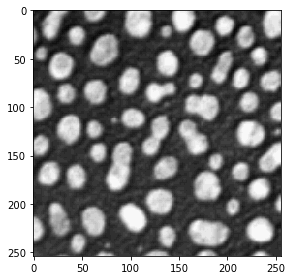

In [4]:
from skimage.io import imread, imshow

image = imread("../../data/blobs.tif")
imshow(image)

The `cle.` gateway has all methods you need, it does not have sub-packages:

C:\Users\rober\miniconda3\envs\bio_39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


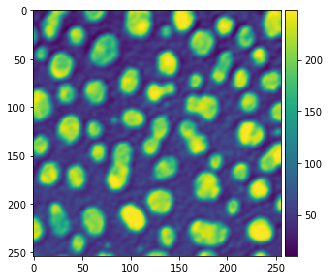

In [5]:
# noise removal
blurred = cle.gaussian_blur(image, sigma_x=1, sigma_y=1)

imshow(blurred)

C:\Users\rober\miniconda3\envs\bio_39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


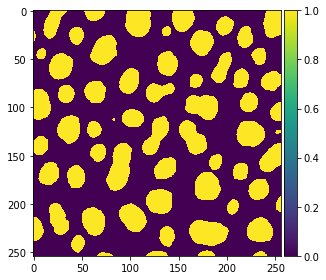

In [6]:
# binarization
binary = cle.threshold_otsu(blurred)

imshow(binary)

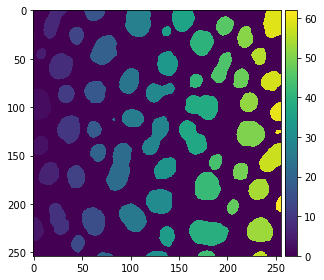

In [7]:
# labeling
labels = cle.connected_components_labeling_box(binary)

# visualize results
imshow(labels)

`cle.` also comes with an imshow function, that allows for example showing label images more conveniently:

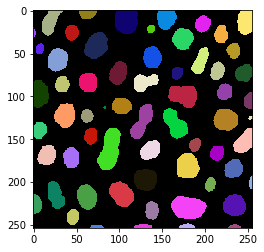

In [8]:
cle.imshow(labels, labels=True)

One can also determine label edges and blend them over the image.

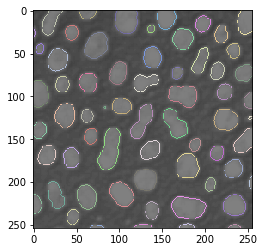

In [9]:
label_edges = cle.detect_label_edges(labels) * labels

cle.imshow(image, alpha=0.5, continue_drawing=True, color_map="Greys_r")
cle.imshow(label_edges, labels=True, alpha=0.5)

Therefore, it may make sense to increase the figure and combine multiple sub-plots

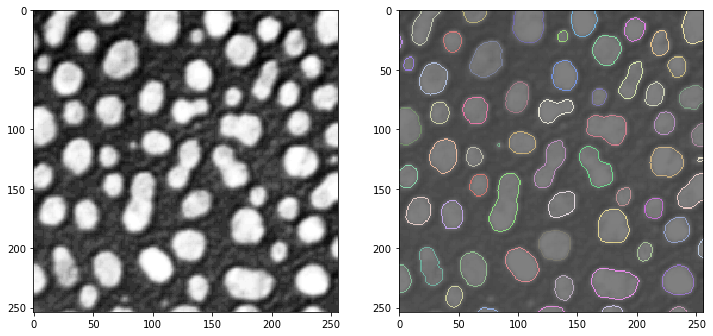

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12,12))

# left plot
cle.imshow(image, color_map="Greys_r", plot=axs[0])

# right plot
cle.imshow(image, alpha=0.5, continue_drawing=True, color_map="Greys_r", plot=axs[1])
cle.imshow(label_edges, labels=True, alpha=0.5, plot=axs[1])

Some of these operations, e.g. [voronoi_otsu_labeling](https://nbviewer.jupyter.org/github/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb) are in fact short-cuts and combine a number of operations such as Gaussian blur, Voronoi-labeling and Otsu-thresholding to go from a raw image to a label image directly:

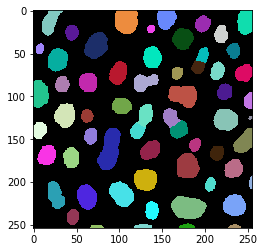

In [11]:
labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5, outline_sigma=1)

cle.imshow(labels, labels=True)

Also, just a reminder, read the documentation of methods you haven't used before:

In [12]:
print(cle.voronoi_otsu_labeling.__doc__)

Labels objects directly from grey-value images.

    The two sigma parameters allow tuning the segmentation result. Under the hood,
    this filter applies two Gaussian blurs, spot detection, Otsu-thresholding [2] and Voronoi-labeling [3]. The
    thresholded binary image is flooded using the Voronoi tesselation approach starting from the found local maxima.
    
    Parameters
    ----------
    source : Image
        Input grey-value image
    label_image_destination : Image, optional
        Output image
    spot_sigma : float
        controls how close detected cells can be
    outline_sigma : float
        controls how precise segmented objects are outlined.
    
    Returns
    -------
    label_image_destination
    
    Examples
    --------
    >>> import pyclesperanto_prototype as cle
    >>> cle.voronoi_otsu_labeling(source, label_image_destination, 10, 2)
    
    References
    ----------
    .. [1] https://clij.github.io/clij2-docs/reference_voronoiOtsuLabeling
    .. [2]

## Interoperability 
In pyclesperanto, images are handled in the random access memory (RAM) of your GPU. If you want to use other libraries, which process images on the GPU, the memory must be transferred back. Usually, this happens transparently for the user, e.g. when using scikit-image for measuring region properties:

In [13]:
from skimage.measure import regionprops

statistics = regionprops(labels)

import numpy as np
np.mean([s.area for s in statistics])

3.1147542

If you want to explicitly convert your image, e.g. into a numpy array, you can do it like this:

In [14]:
np.asarray(labels)

array([[ 0,  0,  0, ..., 57, 57, 57],
       [ 0,  0,  0, ..., 57, 57, 57],
       [ 0,  0,  0, ..., 57, 57, 57],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)

## Memory management
In jupyter noteboooks, variables are kept alive as long as the notebook kernel is running. Thus, your GPU may fill up with memory. Thus, if you don't need an image anymore, set it to `None`. It will then be remove from GPU memory thanks to [pyopencl](https://documen.tician.de/pyopencl/) magic.

In [15]:
image = None
blurred = None
binary = None
labels = None

## Napari integration
For processing 3D image data it is recommended to use a 3D-viewer such as [napari](https://napari.org):

In [16]:
import napari

# start viewer
viewer = napari.Viewer(ndisplay=3)

# load image
from skimage.io import imread
image = imread("../../data/Lund_000500_resampled-cropped.tif")

viewer.add_image(image)

Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.


<Image layer 'image' at 0x174ca6fd160>

In napari, you can change the view to see different layers side-by-side.

In [17]:
viewer.grid.enabled = True

You can also turn the camera angle

In [18]:
viewer.camera.angles = (10, -30, -30)

Next, we process the image and put the segmented image into napari as new layer.

In [19]:
background_subtracted = cle.top_hat_box(image, radius_x=10, radius_y=10, radius_z=10)

labels = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=2, outline_sigma=1)

viewer.add_labels(labels)

<Labels layer 'labels' at 0x174cdb1abe0>

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


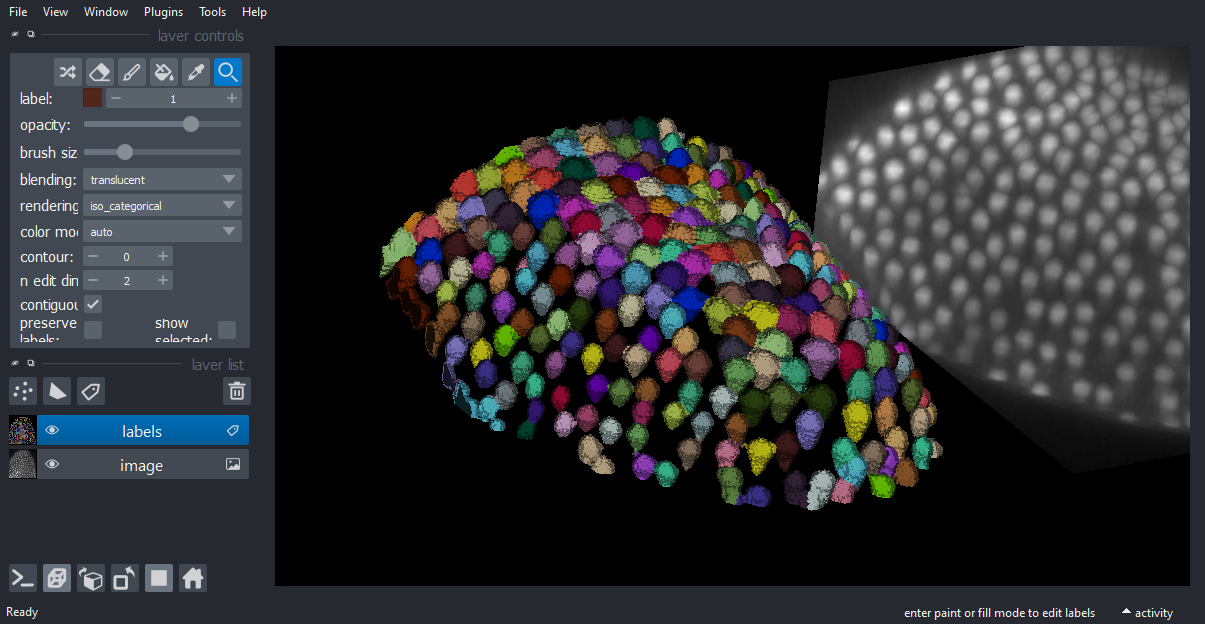

In [20]:
napari.utils.nbscreenshot(viewer)